# Improving Employee Retention by Predicting Employee Attrition Using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import shap
import waterfall_chart as wfall

from category_encoders import OneHotEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from textwrap import wrap
from xgboost import XGBClassifier

pd.options.display.max_columns = None

custom_rc = {'figure.figsize': (12,8),
             'axes.labelsize': 14,
             'figure.titlesize': 18}
rcParams.update(custom_rc)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('ggplot')

## About This Dataset

[This](https://docs.google.com/spreadsheets/d/1EQlE-TUc06O1-HBRP-siI3ZV_4g48-68/edit?rtpof=true) dataset is provided by Rakamin Academy. Based on quick google search, this dataset is adapted from [Human Resource Data Set](https://www.kaggle.com/datasets/rhuebner/human-resources-data-set?select=HRDataset_v14.csv) on Kaggle complying to their license. Other than the columns' names being translated, there are some columns added and some being removed.

In this project, a company dealing with high attrition rate needs to take a data-driven decision. For that, I'm tasked to help solve that problem starting from making inferential analysis to making machine learning model to make recommendations.

In [3]:
filepath = "Improving Employee Retention by Predicting Employee Attrition Using Machine Learning.csv"
df_raw = pd.read_csv(filepath)
df = df_raw.copy()
df.head()

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,4,4.0,0.0,0.0,9.0,+6282232522xxx,spiritedPorpoise3135@yahoo.com,Magister,1,1.0,masih_bekerja,1972-07-01,2011-01-10,2016-2-15,-
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,4,4.0,4.0,0.0,3.0,+6281270745xxx,jealousGelding2239@yahoo.com,Sarjana,1,1.0,toxic_culture,1984-04-26,2014-01-06,2020-1-17,2018-6-16
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,4,3.0,0.0,0.0,11.0,+6281346215xxx,pluckyMuesli3961@icloud.com,Magister,1,1.0,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-9-24
3,stressedTruffle1,106325,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,3,3.0,0.0,4.0,6.0,+6283233846xxx,stressedTruffle1406@hotmail.com,Sarjana,1,0.0,masih_bekerja,1979-11-24,2014-2-17,2020-02-04,-
4,shyTermite7,111171,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,3,3.0,0.0,0.0,11.0,+6287883263xxx,shyTermite7149@gmail.com,Sarjana,1,0.0,ganti_karir,1974-11-07,2013-11-11,2020-1-22,2018-09-06


## Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Username                            287 non-null    object 
 1   EnterpriseID                        287 non-null    int64  
 2   StatusPernikahan                    287 non-null    object 
 3   JenisKelamin                        287 non-null    object 
 4   StatusKepegawaian                   287 non-null    object 
 5   Pekerjaan                           287 non-null    object 
 6   JenjangKarir                        287 non-null    object 
 7   PerformancePegawai                  287 non-null    object 
 8   AsalDaerah                          287 non-null    object 
 9   HiringPlatform                      287 non-null    object 
 10  SkorSurveyEngagement                287 non-null    int64  
 11  SkorKepuasanPegawai                 282 non-n

Most of the features in the dataset are self explanatory, however I will still cross-reference with the source dataset description. The columns' descriptions are as follows:
- **Username**: Employee's username
- **EnterpriseID**: Employee's unique id
- **StatusPernikahan**: Employee's marital status
- **JenisKelamin**: Employee's gender
- **StatusKepegawaian**: Employee's employment status
- **Pekerjaan**: Employee's job position
- **JenjangKarir**: Which career progression the employee is in
- **PerformancePegawai**: Employee's performance score notated in 5 ordinal scores
- **AsalDaerah**: Employee's city of origin
- **HiringPlatform**: What platform was used to hire the employee
- **SkorSurveyEngagement**: Employee's engagement towards company on scale 1-5
- **SkorKepuasanPegawai**: Employee's satisfaction towards company on scale 1-5
- **JumlahKeikutsertaanProjek**: Number of times the employee participated in projects
- **JumlahKeterlambatanSebulanTerakhir**: Employee's tardiness in the last 1 month
- **JumlahKetidakhadiran**: Number of times the employee is absent
- **NomorHP**: Employee's phone number
- **Email**: Employee's email address
- **TingkatPendidikan**: Employee's last education level
- **PernahBekerja**: Denotes whether the employee has worked previously or not
- **IkutProgramLOP**: Denotes whether the employee has joined *Laptop Ownership Program* or not
- **AlasanResign**: Employee's reason for resigning if they do resign
- **TanggalLahir**: Employee's date of birth
- **TanggalHiring**: Employee's date of hiring
- **TanggalPenilaianKaryawan**: Employee's date of last performance review
- **TanggalResign**: Employee's date of resignation

## EDA
I will start with some quick Analysis to understand the dataset better. Let's separate the columns into groups based on their types of data.

In [5]:
identifier = ['Username', 'EnterpriseID', 'NomorHP', 'Email']
date_col = ['TanggalLahir', 'TanggalHiring', 'TanggalPenilaianKaryawan', 'TanggalResign']
nums = ['JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran']
cats = df.drop(identifier + date_col + nums, axis=1).columns

### Descriptive Analysis

In [6]:
df[identifier].astype('object').describe().T

,count,unique,top,freq
Username,287,285,boredEggs0,2
EnterpriseID,287,287,111065,1
NomorHP,287,287,+6282232522xxx,1
Email,287,287,spiritedPorpoise3135@yahoo.com,1


For some reason, there is duplicated **Username** found. However, everything else are unique as expected, which means there is no need to check for duplicated rows in this dataset.

In [7]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
JumlahKeikutsertaanProjek,284.0,1.179577,2.294441,0.0,0.0,0.0,0.0,8.0
JumlahKeterlambatanSebulanTerakhir,286.0,0.412587,1.275016,0.0,0.0,0.0,0.0,6.0
JumlahKetidakhadiran,281.0,10.448399,6.902252,1.0,5.0,10.0,15.0,55.0


In [8]:
df[cats].astype('object').describe().T

,count,unique,top,freq
StatusPernikahan,287,5,Belum_menikah,132
JenisKelamin,287,2,Wanita,167
StatusKepegawaian,287,3,FullTime,217
Pekerjaan,287,14,Software Engineer (Back End),109
JenjangKarir,287,3,Freshgraduate_program,169
PerformancePegawai,287,5,Biasa,85
AsalDaerah,287,5,Jakarta Pusat,72
HiringPlatform,287,9,Indeed,85
SkorSurveyEngagement,287,5,3,132
SkorKepuasanPegawai,282.0,5.0,3.0,96.0


In [9]:
df[date_col].describe().T

,count,unique,top,freq
TanggalLahir,287,284,1987-06-14,2
TanggalHiring,287,97,2011-01-10,12
TanggalPenilaianKaryawan,287,127,2020-1-14,17
TanggalResign,287,53,-,198


### Checking Features' Values

In [10]:
na_col = []
print('Unique values on non-date features:')
for col in df.drop(date_col + identifier, axis=1).columns:
    if df[col].isna().any():
        na_col.append(col)
    print(f'{col}:')
    print(f'\t{df[col].unique()}\n')

Unique values on non-date features:
StatusPernikahan:
	['Belum_menikah' 'Menikah' 'Bercerai' 'Lainnya' '-']

JenisKelamin:
	['Pria' 'Wanita']

StatusKepegawaian:
	['Outsource' 'FullTime' 'Internship']

Pekerjaan:
	['Software Engineer (Back End)' 'Data Analyst'
 'Software Engineer (Front End)' 'Product Manager'
 'Software Engineer (Android)' 'Scrum Master'
 'Product Design (UX Researcher)' 'Product Design (UI & UX)'
 'Digital Product Manager' 'Data Engineer' 'Software Engineer (iOS)'
 'DevOps Engineer' 'Software Architect' 'Machine Learning Engineer']

JenjangKarir:
	['Freshgraduate_program' 'Senior_level' 'Mid_level']

PerformancePegawai:
	['Sangat_bagus' 'Sangat_kurang' 'Bagus' 'Biasa' 'Kurang']

AsalDaerah:
	['Jakarta Timur' 'Jakarta Utara' 'Jakarta Pusat' 'Jakarta Selatan'
 'Jakarta Barat']

HiringPlatform:
	['Employee_Referral' 'Website' 'Indeed' 'LinkedIn' 'CareerBuilder'
 'Diversity_Job_Fair' 'Google_Search' 'On-line_Web_application' 'Other']

SkorSurveyEngagement:
	[4 3 2 1 5]



In [11]:
print('Columns with missing values:')
for col in na_col:
    print(f'* {col}')

Columns with missing values:
* SkorKepuasanPegawai
* JumlahKeikutsertaanProjek
* JumlahKeterlambatanSebulanTerakhir
* JumlahKetidakhadiran
* IkutProgramLOP
* AlasanResign


Based on observation from descriptive analysis, here are the method in handling missing values on those columns:
- **SkorKepuasanPegawai** will be filled with mode, indicating their employment satisfaction to be average
- **JumlahKeikutsertaanProjek** will be filled with 0, indicating they haven't participate in any projects
- **JumlahKeterlambatanSebulanTerakhir** will be filled with 0, indicating they haven't been tardy in the last month
- **JumlahKetidakhadiran** will be filled with 0, indicating they haven't been absent
- **IkutProgramLOP** will be filled with 0, indicating they don't participate in LOP program
- **AlasanResign** will be filled with 'masih_bekerja', indicating they are still working in the company

Aside from 6 columns having missing values, there are some columns with questionable values such as:
- In **StatusPernikahan**, there is a value of '-' which might indicates single status, however it's unclear so it should be combined into 'Lainnya' or 'Others' value
- In **PernahBekerja**, there are only value of 1 and 'yes' which means after changing 'yes' to 1, this column will have singular value and need to be dropped
- In **AlasanResign**, there is a value 'Product Design (UI & UX)' which is not clear in the context of resigning reason, however let's leave this be for now

## Data Preprocessing

### Handling Missing Values

Missing values will be handled according to previous analysis.

In [12]:
df['SkorKepuasanPegawai'].fillna(df.SkorKepuasanPegawai.mode()[0], inplace=True)
fill_zero = ['JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'IkutProgramLOP']
for col in fill_zero:
    df[col].fillna(0, inplace=True)
df['AlasanResign'].fillna('masih_bekerja', inplace=True)

### Cleaning Columns' Values and Datatypes

This part includes handling **StatusPernikahan** and **PernahBekerja** according to previous analysis. On top of that, to standardize the format for **TanggalResign**, the value '-' will be changed into an arbitrary date of '2100-1-1' to indicate employees who are still working.

In [13]:
df['StatusPernikahan'].replace('-', 'Lainnya', inplace=True)
df['PernahBekerja'].replace('yes', '1', inplace=True)
df['TanggalResign'].replace('-', '2100-1-1', inplace=True)
df.PernahBekerja.value_counts()

1    287
Name: PernahBekerja, dtype: int64

As expected previously, **PernahBekerja** column does indeed have singular value, thus it will be dropped.

In [14]:
# Standardize ordinal columns to int64 datatypes
float_col = df.select_dtypes('float')
df[float_col.columns] = float_col.astype('int64')

# Change datatype of date columns into datetime
df[date_col] = df.apply(lambda x: pd.to_datetime(x[date_col], 
                format='%Y-%m-%d', errors='ignore'), axis=1)

# Drop identifier columns and PernahBekerja
df.drop(identifier, axis=1, inplace=True)
df.drop('PernahBekerja', axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   StatusPernikahan                    287 non-null    object        
 1   JenisKelamin                        287 non-null    object        
 2   StatusKepegawaian                   287 non-null    object        
 3   Pekerjaan                           287 non-null    object        
 4   JenjangKarir                        287 non-null    object        
 5   PerformancePegawai                  287 non-null    object        
 6   AsalDaerah                          287 non-null    object        
 7   HiringPlatform                      287 non-null    object        
 8   SkorSurveyEngagement                287 non-null    int64         
 9   SkorKepuasanPegawai                 287 non-null    int64         
 10  JumlahKeikutsertaanProjek 

## Annual Report on Employee Number Changes

After the data is cleaned, the next task will be to analyze the employment's health by checking on employee number changes. In this task, some feature extraction might be needed to visualize the data better. Employee number changes will be analyzed by calculating total employees every year to see the changes due to hiring and resigning of employees. The company's employment is healthy when they can get more employees hired compared to employees resigning.

In [16]:
emp_dates = df[['TanggalHiring', 'TanggalResign']].copy()

emp_dates['TahunHiring'] = emp_dates['TanggalHiring'].dt.year
emp_dates['TahunResign'] = emp_dates['TanggalResign'].dt.year

emp_dates.head(5)

,TanggalHiring,TanggalResign,TahunHiring,TahunResign
0,2011-01-10,2100-01-01,2011,2100
1,2014-01-06,2018-06-16,2014,2018
2,2011-01-10,2014-09-24,2011,2014
3,2014-02-17,2100-01-01,2014,2100
4,2013-11-11,2018-09-06,2013,2018


In [17]:
# Count total employees hired per year
hired = emp_dates.groupby('TahunHiring')[['TanggalHiring']].count().reset_index()
hired.columns = ['Year', 'Hired']

# Count total employees resigned per year
resign = emp_dates.groupby('TahunResign')[['TanggalHiring']].count().reset_index()
resign.columns = ['Year', 'Resigned']

# Left join both dataframe
emp_changes = pd.merge(hired, resign, how='outer', on='Year')

Since year '2100' is the arbitrary number to indicate employees who are still working, that row will be dropped. The missing values for this dataframe will then be filled with 0 to indicate no change.

In [18]:
emp_changes.drop(emp_changes[emp_changes.Year == 2100].index, inplace=True)
emp_changes.fillna(0, inplace=True)
emp_changes = emp_changes.astype('int64')

In [19]:
emp_changes['EmpGrowth'] = emp_changes['Hired'] - emp_changes['Resigned']
emp_changes.head(3)

,Year,Hired,Resigned,EmpGrowth
0,2006,1,0,1
1,2007,2,0,2
2,2008,2,0,2


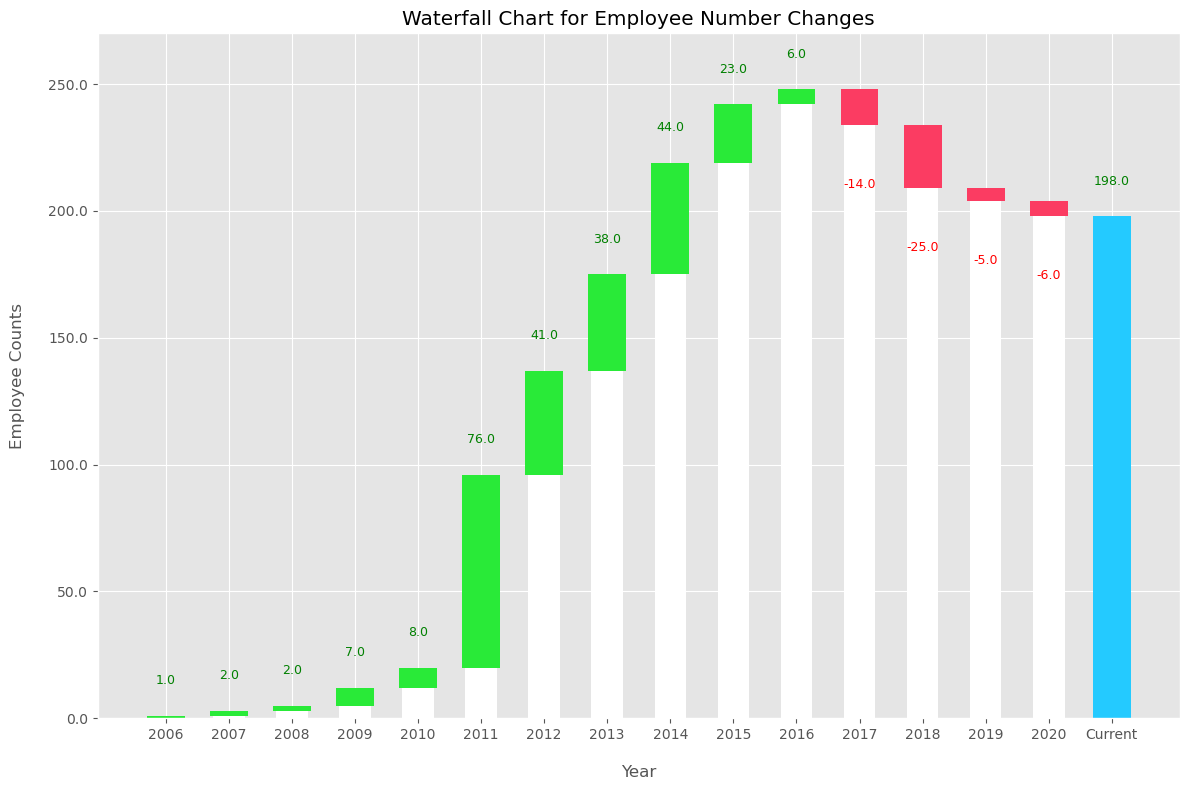

In [20]:
wfall.plot(emp_changes['Year'].astype('str'), 
           emp_changes['EmpGrowth'],
           rotation_value=0,
           net_label='Current',
           Title='Waterfall Chart for Employee Number Changes',
           y_lab='Employee Counts',
           x_lab='Year',)
plt.ylim(0, 270)
plt.show()

In [21]:
# Employee count before 2018
bef18 = emp_changes[emp_changes.Year < 2018]['EmpGrowth'].sum()

# Employee count before 2019
aft18 = emp_changes[emp_changes.Year < 2019]['EmpGrowth'].sum()

# Count difference
left18 = abs(aft18 - bef18)

# Calulating biggest turn over at 2018
turn_over_rate = left18 * 100 / ((aft18 + bef18) / 2)
print(f'Year 2018 turnover rate: {turn_over_rate:.2f}%')

Year 2018 turnover rate: 11.29%


Based on the graph above, the company actually has healthy employment status up until 2016. There was a good upward trend on employment rate starting on year 2011 that slowed down on 2016. Employment rate going down after that until current time, however turnover rate seems to be tolerable at a glance. Worst turnover can be observed at year 2018 with 11.29% turn over rate that's higher than 10% (tolerable turnover rate according to general rule of thumbs). Unfortunately, I only have data of year 2022 for [industry average turnover rate](https://www.linkedin.com/business/talent/blog/talent-strategy/industries-with-the-highest-turnover-rates#:~:text=compared%20with%20the%20overall%20average%20of%2010.6%25) to compare.

The upward trend on employment rate might be attributed to the growing amount of data worldwide benefiting tech companies. This growing amount of data shows an upward trend from 2010 to 2020 according to [Nasdaq](https://www.nasdaq.com/articles/a-decade-of-change%3A-how-tech-evolved-in-the-2010s-and-whats-in-store-for-the-2020s#:~:text=AI%20and%20Big%20Data%20Took%20Off). The slowing down of employment rate on 2015 and 2016 might be attributed to the company's [resource maturity](https://www.upwork.com/resources/stages-of-business-growth#resource-maturity:~:text=After%20a%20successful%20take%2Doff%20where%20the%20company%20has%20achieved%20the%20rapid%20growth%20it%20aimed%20for%2C%20the%20main%20concern%20of%20businesses%20entering%20the%20resource%20maturity%20stage%20is%20proper%20management%20of%20the%20financial%20gains%20from%20the%20last%20phase).

The downward trend on year 2017 might be attributed to change in world economy. This change opens up more job opportunities that leads to trend in switching jobs according to [CNN](https://money.cnn.com/2017/12/28/news/economy/jobs-2017/index.html#:~:text=Another%20sign%20of,plenty%20of%20options.).

## Resign Reason Analysis for Employee Attrition Management Strategy

After analyzing employee number changes, next will be analyzing management strategy going forward. In this task, analysis will be done by observing turnover rate between job roles in the company.

### Retention by Job

In [22]:
# Count of employees who are still working based on role
job_retain = df[df.AlasanResign == 'masih_bekerja'].groupby('Pekerjaan')[['StatusKepegawaian']].count().reset_index()
job_retain.columns = ['Pekerjaan', 'EmpStay']

# Count of employees who resigned based on role
job_resign = df[df.AlasanResign != 'masih_bekerja'].groupby('Pekerjaan')[['StatusKepegawaian']].count().reset_index()
job_resign.columns = ['Pekerjaan', 'EmpResign']

job_status = pd.merge(job_retain, job_resign, on='Pekerjaan', how='outer')
job_status.fillna(0, inplace=True)
job_status[['EmpStay', 'EmpResign']] = job_status[['EmpStay', 'EmpResign']].astype('int64')

In [23]:
job_status['TotalEmp'] = job_status['EmpStay'] + job_status['EmpResign']
job_status['RetentionRate'] = job_status['EmpStay'] * 100 / job_status['TotalEmp']

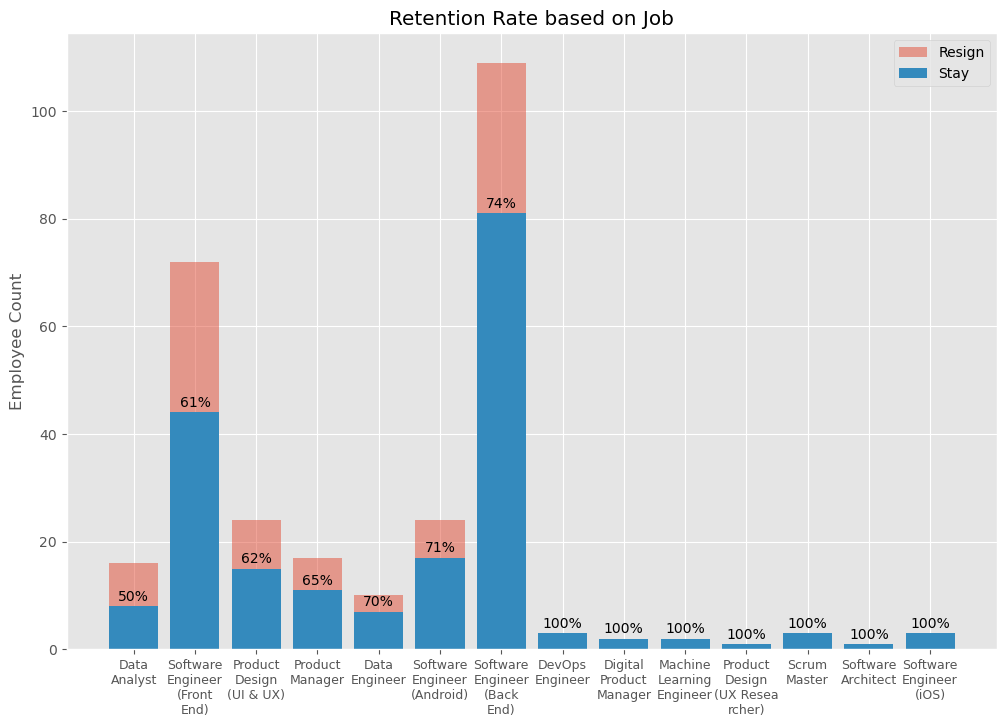

In [24]:
plt.title('Retention Rate based on Job')

# Sort based on retention rate
sort_retention = job_status.sort_values(by='RetentionRate')

wrapped_labels = ['\n'.join(wrap(label, 9)) for label in sort_retention['Pekerjaan']]
plt.bar(wrapped_labels, sort_retention['EmpResign'], 
        bottom=sort_retention['EmpStay'], label='Resign', alpha=.5)
plt.bar(wrapped_labels, sort_retention['EmpStay'], label='Stay')

for i, rate in enumerate(sort_retention['RetentionRate']):
    plt.text(i, sort_retention['EmpStay'].iloc[i] + 1, f'{rate:.0f}%', ha='center')
plt.xticks(size=9)
plt.xlabel('')
plt.ylabel('Employee Count')
plt.legend()
plt.show()


Based on the graph above, it can be observed that 'Data Analyst' has the highest turn over rate in this company at 50%. However, total count of resigned employees are highest in between 'Front End Engineer' and 'Back End Engineer'.

### Employee Attrition Analysis on Highest Turnover Role

As mentioned before, the highest turnover is observed on 'Data Analyst' role. A closer look will be needed to get a better understanding on this role.

In [25]:
top_turnover = ['Data Analyst']
group = ['JenjangKarir', 'PerformancePegawai', 'AlasanResign']
df_resign = df[(df.AlasanResign != 'masih_bekerja') &
               (df.Pekerjaan.isin(top_turnover))].groupby(group)\
               ['AsalDaerah'].count().reset_index()
df_resign.columns = ['JenjangKarir', 'PerformancePegawai', 'AlasanResign'] + ['TotalResign']

In [26]:
fig = px.sunburst(df_resign, 
                  path=['JenjangKarir', 'AlasanResign', 'PerformancePegawai'], 
                  values='TotalResign')

fig.update_traces(insidetextorientation='horizontal',
                  textfont={'size': 15, 'color': "black"})

fig.update_layout(title={'text':'Sunburst Chart for Resigned Data Analyst',
                         'x': 0.5,
                         'font': {'size': 25}}, 
                  margin={'b':10})

fig.show()

Based on the sunburst chart above, here are the findings from Data Analyst turnover data:
- All of the resigned Data Analysts are in freshgraduate program
- For reasoning behind resignation, 75% answered 'toxic culture' while 25% answered 'internal conflict'
- Only 1 resigned Data Analysts is underperforming, while the other majority performs rather well

Based on the findings, one safe assumption to take is that these resigned Data Analysts are on the [younger side](https://1huddle.co/blog/10-facts-you-should-know-about-employee-turnover/#:~:text=YOUNGER%20EMPLOYEES%20ARE%20MOST%20LIKELY%20TO%20TURNOVER) since they are under freshgraduate program. The reasons behind resignation are basically a problem with coworkers and possibly [leadership problem](https://www.aesc.org/insights/blog/business-leaders-believe-wrong-leadership-top-reason-toxic-work-culture#:~:text=nearly%20300%20C%2Dlevel%20business%20leaders%20across%20the%20globe%20cite%20%E2%80%98wrong%20leadership%E2%80%99%20as%20the%20top%20reason%20for%20toxic%20work%20culture). Without additional data, the biggest suspect will be leadership problem. These younger employees are most likely having problems with the work culture that's already cultivated by the older employees. If the work culture is often seen as being toxic, there is a possibility that the leadership roles aren't solving the issue, or worse they are the issue.

Here are the recommendations towards solving this problem:
- Reevaluate the company's leadership structure
- Fascilitate a safe space for employees to speak their concerns and act on it

## Machine Learning Modeling

While the company is on a downward trend in its employee number growth, the company needs a system to predict for the resign possibilities within current employees. This system will be made in order to solve the problems for the problem in the early stages, so they can start to map possible dissatisfied employees in the retention program to prevent more turnover. 

Machine learning will be used to help automate this detection system. However, some concern that has to be addressed will be possible bias in form of racism or gender-based decision. In this task, another preprocessing will be done to prepare the data for modeling. This preprocessing will include feature selection to address the aforementioned concern.

To understand what metrics to use, the business impact of each confusion matrix elements will be as follow:
- True Positive (TP): employees that will resign are predicted correctly, they will get mapped to join retention program
- True Negative (TN): employees that will NOT resign are predicted correctly, they are staying employees
- False Positive (FP): employees that will NOT resign are predicted to resign, resulting in **retention program filled with staying employees**
- False Negative (FN): employees that will resign are predicted to NOT resign, resulting in **employees resigning without getting handled**

Based on that analysis, there is a difference in importance between FP and FN. FN will be more of a concern since the goal is to reduce turnover rate by sending possible turnover employees to retention program. Compared to that, there is little to no harm for FP since staying employees will most likely stay either way.

Putting that into consideration, the metrics we will be focusing is **True Positive Rate** or **Recall** in cross validation.

### Target Labeling and Feature Selection
Based on previous preprocessing, some aspects that were already cleaned up are as follows:
- No duplicated data found, each rows are different individual employees
- No missing values after some inputations

Based on that summary, those steps will be skipped here.

Let's start by giving a target label to our dataset first. The prediction target will be to predict whether an employee will resign or not, so our target label will be based on whether an employee is still working or not.

In [27]:
df['Resign'] = np.where(df.AlasanResign == 'masih_bekerja', 0, 1)
df[['AlasanResign', 'Resign']].head(3)

,AlasanResign,Resign
0,masih_bekerja,0
1,toxic_culture,1
2,jam_kerja,1


Next will be a preemptive feature selection to address the concern regarding racism, gender-based decision, or other kind of possible discriminations. The following columns will be dropped to remove learning bias based on them:
- **JenisKelamin**: to address gender bias concern so the models will not try to use gender as a pattern to recognize
- **AsalDaerah**: to remove discriminations based on cities of origin
- **HiringPlatform**: hiring platform has no impact towards what happens in the company
- **AlasanResign**: no impact to the prediction because we are trying to prevent this from happening
- All date columns: no impact on real life prediction

In [28]:
drop_col = ['JenisKelamin', 'AsalDaerah', 'HiringPlatform',
            'AlasanResign', 'TanggalLahir', 'TanggalHiring',
            'TanggalPenilaianKaryawan', 'TanggalResign']

x = df.drop('Resign', axis=1)
x.drop(drop_col, axis=1, inplace=True)
y = df['Resign']

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   StatusPernikahan                    287 non-null    object
 1   StatusKepegawaian                   287 non-null    object
 2   Pekerjaan                           287 non-null    object
 3   JenjangKarir                        287 non-null    object
 4   PerformancePegawai                  287 non-null    object
 5   SkorSurveyEngagement                287 non-null    int64 
 6   SkorKepuasanPegawai                 287 non-null    int64 
 7   JumlahKeikutsertaanProjek           287 non-null    int64 
 8   JumlahKeterlambatanSebulanTerakhir  287 non-null    int64 
 9   JumlahKetidakhadiran                287 non-null    int64 
 10  TingkatPendidikan                   287 non-null    object
 11  IkutProgramLOP                      287 non-null    int64 

### Train-Test Split
Train-test split is done before any further preprocessing to reduce data leakage.

In [29]:
random_state = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    random_state=random_state,
                                                    test_size=0.2,
                                                    stratify=y)

In [30]:
y_train.value_counts(normalize=True)

0    0.689956
1    0.310044
Name: Resign, dtype: float64

As can be seen above, the imbalance in training data is on moderate side. Oversampling might be needed to balance the train data later on.

### Handling Outliers on Train Dataset

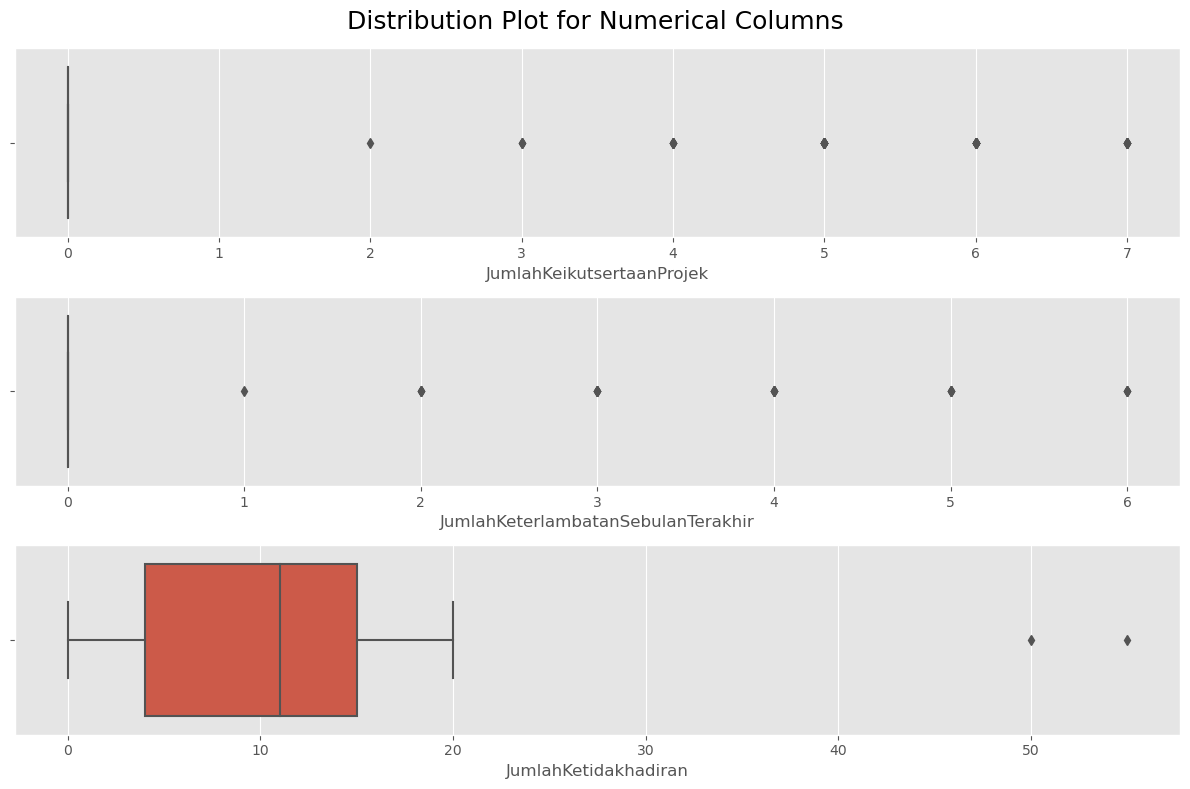

In [31]:
plt.suptitle('Distribution Plot for Numerical Columns')
for i, col in enumerate(nums):
    plt.subplot(3, 1, i+1)
    sns.boxplot(data=x_train, x=col)
plt.tight_layout()
plt.show()

For **JumlahKeikutSertaanProjek** and **JumlahKeterlambatanSebulanTerakhir**, majority of the values are at 0 making every other values fall into outlier. However, since the values aren't that far off from majority, these datas will be left as is and will be addressed with feature scaling later.

For **JumlahKetidakHadiran**, there are outliers found at 50 and above.

In [32]:
x_train[x_train.JumlahKetidakhadiran >= 50]

,StatusPernikahan,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,IkutProgramLOP
115,Lainnya,FullTime,Software Engineer (Front End),Mid_level,Biasa,4,5,0,0,55,Sarjana,0
12,Menikah,FullTime,Software Engineer (Back End),Freshgraduate_program,Biasa,4,3,0,0,50,Magister,0


There is a possibility that these 2 outliers are a result from an inputation error. However, to avoid further assumptions or bias, they will be dropped.

In [33]:
outlier = x_train[x_train.JumlahKetidakhadiran >= 50].index
x_train.drop(outlier, inplace=True)
y_train.drop(outlier, inplace=True)

### Machine Learning Pipeline
To reduce possibilities of data leakage, feature scaling will be done through pipeline.

In [34]:
# Ordinal encoder for PerformancePegawai
perform_order = ['Sangat_kurang', 'Kurang', 'Biasa', 'Bagus', 'Sangat_bagus']
perform_encode = OrdinalEncoder(handle_unknown='use_encoded_value', 
                                unknown_value=-1, 
                                categories=[perform_order])

# Ordinal encoder for TingkatPendidikan
edu_order = ['Sarjana', 'Magister', 'Doktor']
edu_encode = OrdinalEncoder(handle_unknown='use_encoded_value', 
                            unknown_value=-1, 
                            categories=[edu_order])

# One-hot Encoder for other categorical
ohe_col = ['StatusPernikahan', 'StatusKepegawaian',
            'Pekerjaan', 'JenjangKarir']
ohe_encode = OneHotEncoder(handle_unknown=0,
                           handle_missing='error',
                           use_cat_names=True)

# Preprocessing transformer
transformer = ColumnTransformer(
                transformers=[
                    ('performance', perform_encode, ['PerformancePegawai']),
                    ('education', edu_encode, ['TingkatPendidikan']),
                    ('ohe', ohe_encode, ohe_col),
                ], remainder='passthrough')

# Simple imputer to fill NaN values
# caused by missing 'Pekerjaan' due to ohe in train set
imputer = SimpleImputer()

# SMOTE oversampler to balance minority
smote = SMOTE(random_state=random_state, sampling_strategy=1)

# Scaler to user in pipeline
scaler = MinMaxScaler()


In [35]:
# Function to build pipeline
def build_model_pipelines(names, models, transformer=transformer):
    '''Takes 3 inputs:
    names: str[list] of model names
    models: list of models used
    transformer: preprocessing pipelines

    numbers of names must be the same as numbers of models
    
    Returns list of pipelines'''
    assert len(names) == len(models), "numbers of names must be the same as numbers of models"
    pipelines = []

    for i in range(len(names)):
        pipeline = Pipeline([
            ('preprocess', transformer),
            ('impute', imputer),
            ('smote', smote),
            ('scaler', scaler),
            ('classifier', models[i])
        ])
        pipelines.append((names[i], pipeline, models[i]))
    
    return pipelines
    
# Function to run multiple model simultaneously
def run_pipelines(pipelines, cv=5, scoring='recall'):
    '''Takes a list of models, returns prediction result
    
    Input: (label_name, model_pipeline, base_estimator)
    '''
    outputs = []

    for pipeline in pipelines:
        name = pipeline[0]
        model = pipeline[1]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        output = {'Model' : model,
                  'Model Name': name,
                  'Prediction' : y_pred}
        
        output['CV'] = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
        output['scoring'] = scoring
        output['Confusion Matrix'] = confusion_matrix(y_test, y_pred)
        
        outputs.append(output)

    return outputs

def make_evaluations_df(results, y_test=y_test, show_base_model=False):
    '''Takes in results from run_pipelines function.
    
    show_base_model: default = False
    To show parameter tuning if needed
    '''
    evals = []
    for result in results:
        model = result['Model']
        eval = {'Model': model,
                'Model Name': result['Model Name']}
        y_pred = result['Prediction']
        scoring = result['scoring'] 
        
        eval['Accuracy'] = accuracy_score(y_test, y_pred)
        eval['Precision'] = precision_score(y_test, y_pred, zero_division=0)
        eval['Recall'] = recall_score(y_test, y_pred, zero_division=0)
        # eval['F1-score'] = f1_score(y_test, y_pred, zero_division=0)
        # eval['ROC-AUC'] = roc_auc_score(y_test, y_pred)
        # eval[scoring + ' (CV)'] = result['CV'].mean()
        cv_score = cross_validate(model, x_train, y_train, cv=5, return_train_score=True, scoring=scoring)
        eval[scoring + ' (CV Train)'] = cv_score['train_score'].mean()
        eval[scoring + ' (CV Test)'] = cv_score['test_score'].mean()
        
        evals.append(eval)

    df_eval = pd.DataFrame(evals)

    if not show_base_model:
        df_eval.drop('Model', axis=1, inplace=True)

    return df_eval

### Initial Model Selection
After preparing pipelines and evaluation functions, the following models will be used as starting point by comparing recall score:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. AdaBoost
5. XGBoost
6. KNN

In [36]:
logreg = LogisticRegression(random_state=random_state)
dt = DecisionTreeClassifier(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
ada = AdaBoostClassifier(random_state=random_state)
xg = XGBClassifier(random_state=random_state)
knn = KNeighborsClassifier()

names = ['Logistic Regression', 'Decision Tree',
         'Random Forest', 'AdaBoost', 
         'XGB', 'KNN']
models = [logreg, dt, 
          rf, ada, 
          xg, knn]

model_pipelines = build_model_pipelines(names, models)
result = run_pipelines(model_pipelines)
eval_df = make_evaluations_df(result)
eval_df.sort_values(by=['Recall'], ascending=False)

,Model Name,Accuracy,Precision,Recall,recall (CV Train),recall (CV Test)
5,KNN,0.620690,0.444444,0.888889,0.802820,0.449524
0,Logistic Regression,0.551724,0.375000,0.666667,0.616228,0.392381
1,Decision Tree,0.655172,0.444444,0.444444,1.000000,0.269524
3,AdaBoost,0.586207,0.333333,0.333333,0.468421,0.212381
4,XGB,0.586207,0.333333,0.333333,1.000000,0.200000
2,Random Forest,0.637931,0.333333,0.166667,1.000000,0.128571


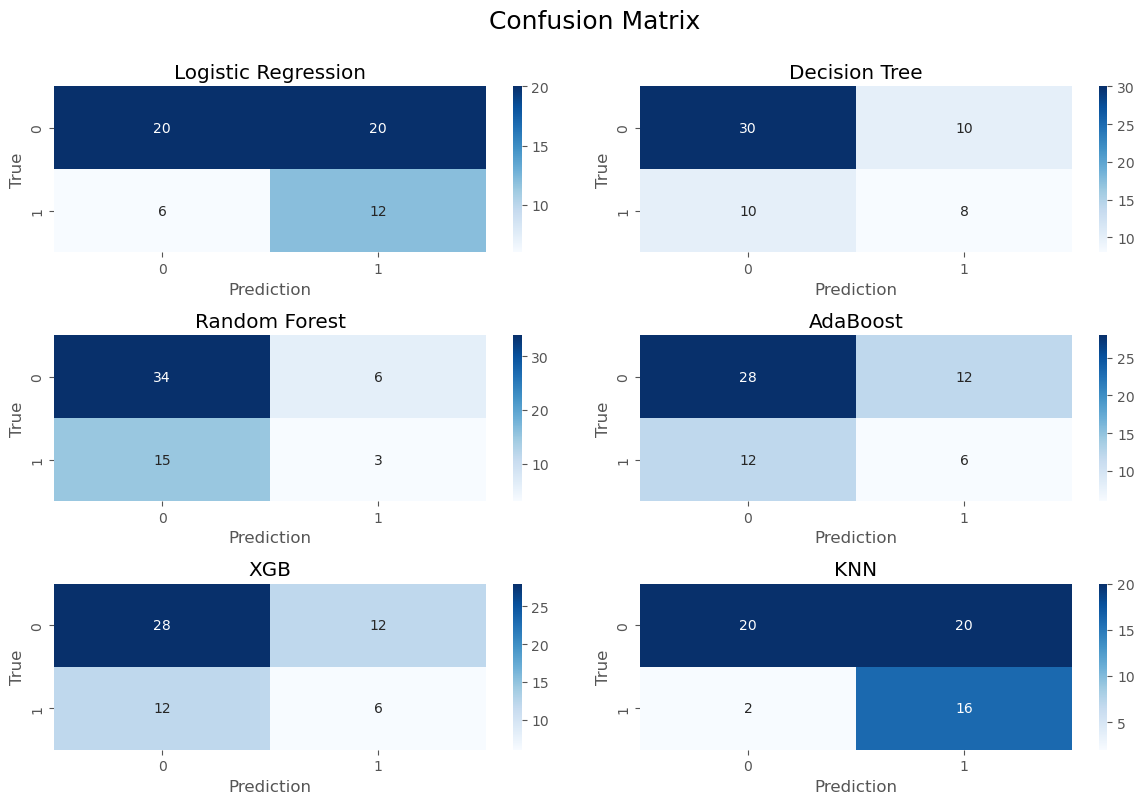

In [37]:
plt.suptitle('Confusion Matrix', y=1)

for i, model in enumerate(result):
    plt.subplot(len(models) //2, 2, i+1)
    plt.title(model['Model Name'])
    cfm = model['Confusion Matrix']
    sns.heatmap(cfm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    
plt.tight_layout()

Based on the table above, most of the results are not very promising aside from **Logistic Regression** and **KNN** with high recall but low precision. The possible reason is due to the lack of data even after oversampling was done. For this project, let's try to limit the hyperparameter tuning to these two.

### Hyperparameter Tuning: Logistic Regression

In [38]:
# Taking pipeline from previous function
logreg_pipeline = result[0]['Model']

In [39]:
param_grid = {
   'classifier__solver': ['lbfgs', 'liblinear'],
   'classifier__random_state': [random_state],
   'classifier__C': [float(x) for x in np.linspace(1, 0.0001, 400)]
}

search = GridSearchCV(logreg_pipeline, scoring='recall', param_grid=param_grid, cv=3)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.5f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.48249):
{'classifier__C': 0.0001, 'classifier__random_state': 42, 'classifier__solver': 'lbfgs'}


In [40]:
best_par = {param.replace('classifier__', ''): value for param, value in search.best_params_.items()}
logreg_rec = LogisticRegression(**best_par)

names = ['LogReg Base', 'LogReg Tune']
models = [logreg, logreg_rec]
model_pipelines = build_model_pipelines(names, models)
result_lr = run_pipelines(model_pipelines)
eval_df = make_evaluations_df(result_lr)

eval_df

,Model Name,Accuracy,Precision,Recall,recall (CV Train),recall (CV Test)
0,LogReg Base,0.551724,0.375,0.666667,0.616228,0.392381
1,LogReg Tune,0.551724,0.375,0.666667,0.682832,0.576190


There is somehow no change in prediction result here. The only change observed is that the CV results improved quite significantly with cv test getting closer to cv train, meaning the model is less overfitting.

### Hyperparameter Tuning: KNN

In [41]:
# Taking pipeline from previous function
knn_pipeline = result[5]['Model']

In [42]:
param_grid = {
   'classifier__weights': ['uniform', 'distance'],
   'classifier__algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'classifier__n_neighbors': [x for x in range(5, 21, 1)],
   'classifier__leaf_size': [x for x in range(5, 51, 5)]
}

search = GridSearchCV(knn_pipeline, scoring='recall', param_grid=param_grid, cv=3)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.5f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.76268):
{'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 5, 'classifier__n_neighbors': 17, 'classifier__weights': 'uniform'}


In [43]:
best_par = {param.replace('classifier__', ''): value for param, value in search.best_params_.items()}
knn_rec = KNeighborsClassifier(**best_par)

names = ['KNN Base', 'KNN Tune']
models = [knn, knn_rec]
model_pipelines = build_model_pipelines(names, models)
result_knn = run_pipelines(model_pipelines)
eval_df = make_evaluations_df(result_knn)

eval_df

,Model Name,Accuracy,Precision,Recall,recall (CV Train),recall (CV Test)
0,KNN Base,0.620690,0.444444,0.888889,0.802820,0.449524
1,KNN Tune,0.517241,0.380952,0.888889,0.827506,0.674286


Unlike LogReg previously, the tuned version is worse than before tuning. While the recall stays the same, both accuracy and precision going down is concerning. Aside from the size of data, another possibility for this behaviour is due to the lack of hyperparameter to explore. 

### Model Comparison

In [44]:
names = ['LogReg Base', 'Decision Tree',
         'Random Forest', 'AdaBoost', 
         'XGB', 'KNN Base', 'LogReg Tune', 'KNN Tune']
models = [logreg, dt, rf, ada, xg, knn, logreg_rec, knn_rec]

model_pipelines = build_model_pipelines(names, models)
result = run_pipelines(model_pipelines)
eval_df = make_evaluations_df(result)
eval_df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

,Model Name,Accuracy,Precision,Recall,recall (CV Train),recall (CV Test)
5,KNN Base,0.620690,0.444444,0.888889,0.802820,0.449524
7,KNN Tune,0.517241,0.380952,0.888889,0.827506,0.674286
0,LogReg Base,0.551724,0.375000,0.666667,0.616228,0.392381
6,LogReg Tune,0.551724,0.375000,0.666667,0.682832,0.576190
1,Decision Tree,0.655172,0.444444,0.444444,1.000000,0.269524
3,AdaBoost,0.586207,0.333333,0.333333,0.468421,0.212381
4,XGB,0.586207,0.333333,0.333333,1.000000,0.200000
2,Random Forest,0.637931,0.333333,0.166667,1.000000,0.128571


Judging by their tradeoffs, **KNN Base** might be the best out of these. That being said, it might be a good idea to take a closer look on the confusion matrix for the top 4 models based on recall here.

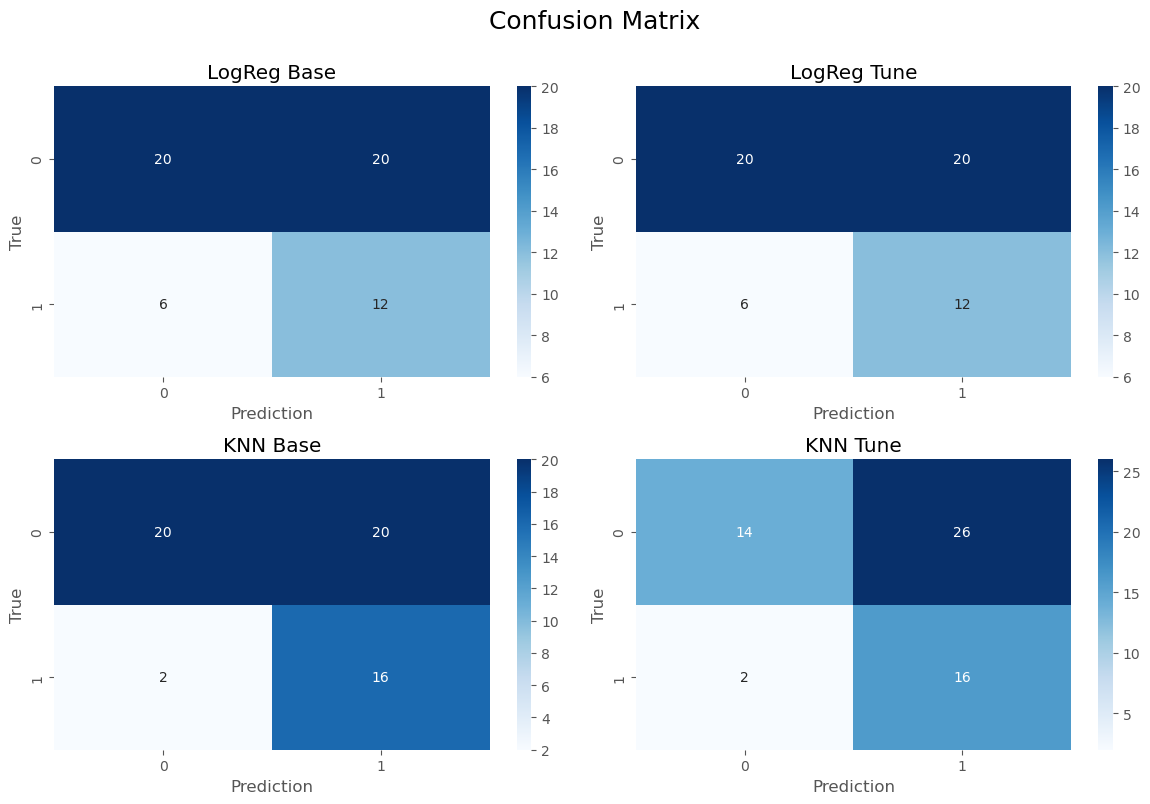

In [45]:
names = ['LogReg Base', 'LogReg Tune',
         'KNN Base', 'KNN Tune']
models = [logreg, logreg_rec, knn, knn_rec]

model_select = build_model_pipelines(names, models)
final = run_pipelines(model_select)

plt.suptitle('Confusion Matrix', y=1)

for i, model in enumerate(final):
    plt.subplot(len(models) //2, 2, i+1)
    plt.title(model['Model Name'])
    cfm = model['Confusion Matrix']
    sns.heatmap(cfm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    
plt.tight_layout()

Unfortunately, the trade offs will be somewhat big for this problem. Here are the analysis:
- There is no change in result for **Logistic Regression** between before and after tuning
- **KNN** has worse performance after tuning where TP and FP stays the same but getting worse in predicting TN
- Between **LogReg Base** and **KNN Base**, **KNN Base** is better due to having better precision

## Result Presentation with XAI
The last task in this project is to simulate result presentation to business users in the company. The metrics used in model evaluation above don't mean much to business users, thus the need for explanable AI. This is done to build trust and transparency to business users by explaining why the model decides its result predictions.

The XAI library used for this project will be SHAP. SHAP explains what features affects the result, how much the impact of each features for prediction, and whether it impacts negatively or positively.

However since the model's processing was done in a black box method using *build_model_pipelines* function, there will be a replication step on what's going inside the function for the preprocessing and smote before running the model.

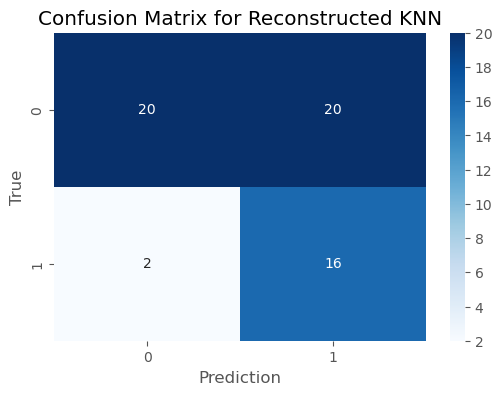

In [111]:
x_shap = x_train.copy()
x_shap_t = x_test.copy()
y_shap = y_train.copy()
y_shap_t = y_test.copy()

# Encode performance
x_shap['PerformancePegawai'] = perform_encode.fit_transform(x_train[['PerformancePegawai']])
x_shap_t['PerformancePegawai'] = perform_encode.transform(x_test[['PerformancePegawai']])

# Encode education
x_shap['TingkatPendidikan'] = edu_encode.fit_transform(x_train[['TingkatPendidikan']])
x_shap_t['TingkatPendidikan'] = edu_encode.transform(x_test[['TingkatPendidikan']])

# OHE
x_shap = pd.concat([x_shap, ohe_encode.fit_transform(x_train[ohe_col])], axis=1)
x_shap.drop(ohe_col, axis=1, inplace=True)
x_shap_t = pd.concat([x_shap_t, ohe_encode.transform(x_shap_t[ohe_col])], axis=1)
x_shap_t.drop(ohe_col, axis=1, inplace=True)

# Imputer
x_shap = pd.DataFrame(imputer.fit_transform(x_shap), columns=x_shap.columns, index=x_shap.index)
x_shap_t = pd.DataFrame(imputer.transform(x_shap_t), columns=x_shap_t.columns, index=x_shap_t.index)

# SMOTE
x_shap, y_shap = smote.fit_resample(x_shap, y_shap)

# scaler
x_shap = pd.DataFrame(scaler.fit_transform(x_shap), columns=x_shap.columns, index=x_shap.index)
x_shap_t = pd.DataFrame(scaler.transform(x_shap_t), columns=x_shap_t.columns, index=x_shap_t.index)

# KNN
knn.fit(x_shap, y_shap)
y_shap_p = knn.predict(x_shap_t)
shap_matrix = confusion_matrix(y_shap_t, y_shap_p)

plt.figure(figsize=(6,4))
plt.title('Confusion Matrix for Reconstructed KNN')
sns.heatmap(shap_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

As can be seen above, result has been replicated outside pipeline. Now to make SHAP graph using the replication.

### SHAP Global Interpretation
Let's start by looking at how the model is making its prediction on the dataset using SHAP

In [51]:
explainer = shap.KernelExplainer(knn.predict_proba, x_shap_t, model_output='probability')
shap_values = explainer.shap_values(x_shap_t)

  0%|          | 0/58 [00:00<?, ?it/s]

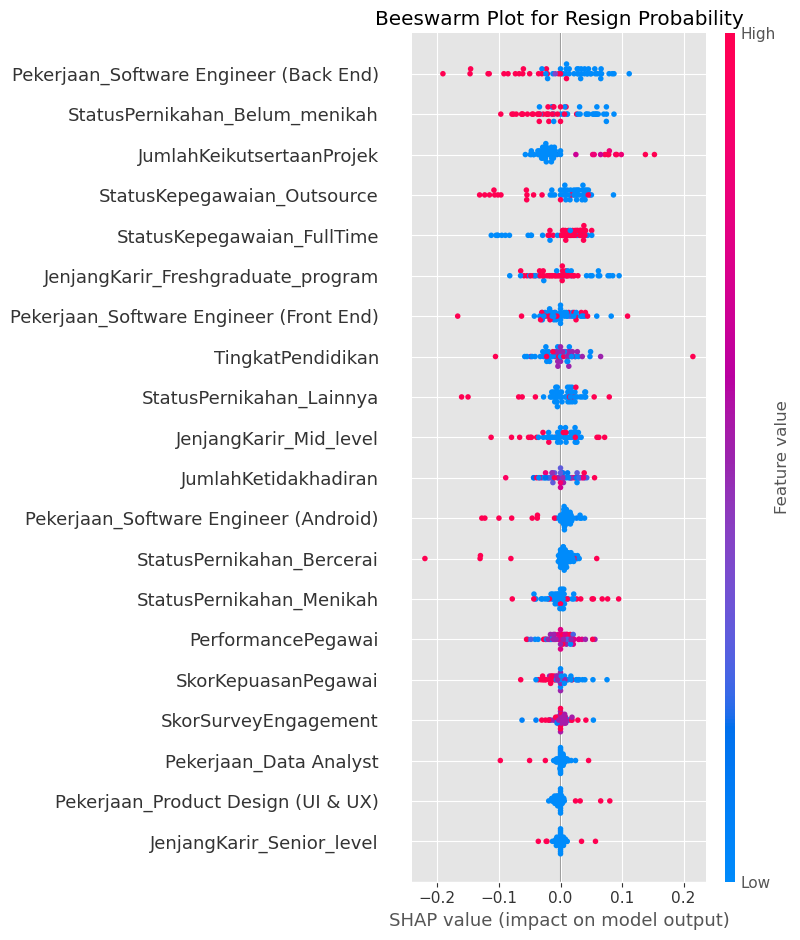

In [52]:
plt.title('Beeswarm Plot for Resign Probability')
shap.summary_plot(shap_values[1], x_shap_t)

From the graph above, there are some interesting observation to be made on how the model made its prediction:
- Employees who do **NOT** work as **Software Engineer (Back End)** have **higher** probability to be labeled as resigning. This decision makes sense considering this job role is the majority in the company. However, this also means that the employees that got misclassified as potential turnover are from other job role due to this.
- Employees whose marital status is **'not married'** have **lower** probability to be labeled as resigning and employees whose marital status is specifically **'married'** ('StatusPernikahan Menikah) have **higher** probability to be labeled as resigning. This is interesting because some statistic like [this](https://www.linkedin.com/pulse/analyzing-attrition-data-married-vs-single-who-stays-kadambi/#:~:text=Married%20males%20leave%20the%20least%2C%20next%20married%20female%20leave%20the%20least.) says otherwise. There might be some need to look further about this topic if needed.
- Employees with **higher participations on projects** have **higher** probability to be labeled as resigning. This decision is somewhat understandable due to possible burnout from projects being the reason for resigning, or lack of compensations or rewards.
- There seems to be a correlation between being Fulltime employees or Outsource employees. **Outsource employees** have **lower** probability, while **Fulltime employees** have **higher** probability to be labeled as resigning. This makes sense considering fulltime employees work directly under the company's management system, so they are more exposed to possible management or work culture problems compared to outsource employees.

### SHAP Local Interpretation
After trying to understand how the model makes its prediction decision on the whole test set, let's analyze it on the sample level to get a better understanding. The KNN model for this project has a good recall score, but low precision. Time to see where the model succeeds and where it fails by looking at a sample of TP and FP each. 

In [65]:
shap.initjs()

In [184]:
df_shap = x_shap_t.copy()
df_shap['Resign'] = y_shap_t
df_shap['Pred'] = y_shap_p
df_shap[df_shap.Pred == 1][['Resign', 'Pred']].head()

,Resign,Pred
68,1,1
195,0,1
234,0,1
227,0,1
285,1,1


Using the table above, our sample for TP is data with index 68, while our sample for FP is data with index 227. Now let's find it's loc index in the dataset.

In [193]:
tp = df_shap.index.get_loc(68)
fp = df_shap.index.get_loc(227)
print(f'Location for index 68 is {tp}')
print(f'Location for index 227 is {fp}')

Location for index 68 is 0
Location for index 227 is 8


In [227]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], x_shap_t.iloc[0,:])

As a sample of predicted resigning employee, here are the insight on understanding this model's decision:
- This employee works as Front End. Getting predicted as resigning by model was pushed by 2 factors, 1 being Back End has the most staying employee counts, and 2 being Front End has the most resigning employee counts.
- This employee has a relatively low absency and high engagement survey score. This makes the model think slightly that this employe will stay, which is on the right logic.

In [229]:
shap.force_plot(explainer.expected_value[1], shap_values[1][8], x_shap_t.iloc[8,:])

As a sample of mispredicted resigning employee, here are the insight on understanding this model's decision:
- This employee is not in freshgraduate program. The model use this feature to strongly predict for resign, while the global interpretation doesn't seem to have a clear distinction whether it affects positively or negatively. This might be one of the features that gives misleading pattern to the model and can be reviewed for the future modeling.
- This employee is not in Back End role and not an outsource employee. This is similar to the analysis on the global interpretation, so this decision is on the right track.
- This employee is in Software Engineer Android role. This role has quite high retention rate in the company, thus the model uses this as consideration that the employee might stay.
- This employee is 'not married'. This decision is probably based on sample data, so this feature having quite some impact is not very clear why.

### Insights and Recommendation from Model Evaluation

Based on logic used by the models, here are some insights that's most logical to take action from:
- Higher participation on projects contributing to higher probability of resigning. This means there is some room for evaluation how the projects are done in the company. Based on observation in resigning reasons and the pattern recognized by our machine learning model, there are some factors that comes to mind regarding this. One possibility is regarding the project rewards, it can be the lack of compensation, or maybe it's not engaging enough.
- Being a full time employee contributes to higher probability of resigning, while being outsource employee is the opposite. This means that there is a discrepancy between the work stress experienced by these 2 types of employees. Considering some resigning reasons are between internal conflict and toxic work culture, this explains why fulltime employees are more likely to resign compared to outsource employees since they are most likely working under different management system.

Based on that insight, the recommendations are:
- Reevaluate projects in the company, especially in regards to compensation and appreciation towards employees with higher participations in them
- Reevaluate in-company's management system and check up on employees regularly to mediate internal conflict